In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments
import torch
from transformers import RobertaConfig, RobertaModel
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
df = pd.read_pickle('AnnoMI-full-with-audio-cleaned-text.pkl')

In [5]:
# make a dataset where intelocutor is client

data_client = df[df['interlocutor'] == 'client']

data_therapist = df[df['interlocutor'] == 'therapist']

In [6]:
# Extract unique class names for client and therapist tasks
client_class_names = df['client_talk_type'].dropna().unique().tolist()
therapist_class_names = df['main_therapist_behaviour'].dropna().unique().tolist()

client_class_names, therapist_class_names

(['neutral', 'change', 'sustain'],
 ['question', 'therapist_input', 'reflection', 'other'])

In [7]:
train_data_client, val_data_client = train_test_split(data_client, test_size=0.2, random_state=42)
train_data_therapist, val_data_therapist = train_test_split(data_therapist, test_size=0.2, random_state=42)

In [8]:
tokenizer_twitter_sentiment = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
tokenizer_distilbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_goemotion = AutoTokenizer.from_pretrained('SamLowe/roberta-base-go_emotions')
tokenizer_distilroberta_emo_base = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
tokernizer_roberta_emo_large = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-roberta-large")
tokenizer_roberta_large = AutoTokenizer.from_pretrained("roberta-large")
tokenizer_distilroberta = AutoTokenizer.from_pretrained("distilroberta-base")

In [9]:
tokenizer = tokenizer_roberta_large

In [10]:
train_encodings_client = tokenizer(train_data_client['utterance_text'].tolist(), truncation=True, padding=True)
val_encodings_client = tokenizer(val_data_client['utterance_text'].tolist(), truncation=True, padding=True)
train_encodings_therapist = tokenizer(train_data_therapist['utterance_text'].tolist(), truncation=True, padding=True)
val_encodings_therapist = tokenizer(val_data_therapist['utterance_text'].tolist(), truncation=True, padding=True)

In [11]:
# 4. Dataset Definition
class MTLDataset(Dataset):
    def __init__(self, client_encodings, therapist_encodings, client_labels, therapist_labels):
        self.client_encodings = client_encodings
        self.therapist_encodings = therapist_encodings
        self.client_labels = client_labels
        self.therapist_labels = therapist_labels

    def __getitem__(self, idx):
        client_item = {key: torch.tensor(val[idx]) for key, val in self.client_encodings.items()}
        therapist_item = {key: torch.tensor(val[idx]) for key, val in self.therapist_encodings.items()}
        client_label = torch.tensor(self.client_labels[idx], dtype=torch.long)
        therapist_label = torch.tensor(self.therapist_labels[idx], dtype=torch.long)
        return client_item, therapist_item, client_label, therapist_label

    def __len__(self):
        return len(self.client_labels)

In [12]:
# Convert string labels to categorical integer values
train_data_client['client_talk_type'] = train_data_client['client_talk_type'].astype('category').cat.codes
val_data_client['client_talk_type'] = val_data_client['client_talk_type'].astype('category').cat.codes

train_data_therapist['main_therapist_behaviour'] = train_data_therapist['main_therapist_behaviour'].astype('category').cat.codes
val_data_therapist['main_therapist_behaviour'] = val_data_therapist['main_therapist_behaviour'].astype('category').cat.codes

In [13]:
train_dataset = MTLDataset(train_encodings_client, train_encodings_therapist, train_data_client['client_talk_type'].to_numpy(), train_data_therapist['main_therapist_behaviour'].to_numpy())
val_dataset = MTLDataset(val_encodings_client, val_encodings_therapist, val_data_client['client_talk_type'].to_numpy(), val_data_therapist['main_therapist_behaviour'].to_numpy())

In [14]:
# 6. Model Definition
class MTLModel(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist):
        super(MTLModel, self).__init__()
        self.shared = RobertaModel.from_pretrained(base_model_name)
        self.client_classifier = nn.Linear(2 * self.shared.config.hidden_size, num_classes_client)
        self.therapist_classifier = nn.Linear(2 * self.shared.config.hidden_size, num_classes_therapist)
        self.attention_weights = nn.Linear(self.shared.config.hidden_size, self.shared.config.hidden_size)
    
    def forward(self, client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name, use_attention=True):
        client_output = self.shared(input_ids=client_input_ids, attention_mask=client_attention_mask)
        therapist_output = self.shared(input_ids=therapist_input_ids, attention_mask=therapist_attention_mask)
        client_pooled = client_output[0][:, 0, :]
        therapist_pooled = therapist_output[0][:, 0, :]
        
        if use_attention:
            attention_logits = client_pooled @ self.attention_weights(therapist_pooled).T
            attention_scores = F.softmax(attention_logits, dim=1)
            weighted_therapist = attention_scores @ therapist_pooled
            joint_embedding = torch.cat([client_pooled, weighted_therapist], dim=1)
        else:
            joint_embedding = torch.cat([client_pooled, therapist_pooled], dim=1)
        
        if task_name == "client":
            return self.client_classifier(joint_embedding)
        elif task_name == "therapist":
            return self.therapist_classifier(joint_embedding)
        
class MTLModelSmall(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist):
        super(MTLModelSmall, self).__init__()
        self.shared = RobertaModel.from_pretrained(base_model_name)
        
        # Update the classifier dimensions
        self.client_classifier = nn.Linear(self.shared.config.hidden_size, num_classes_client)
        self.therapist_classifier = nn.Linear(self.shared.config.hidden_size, num_classes_therapist)
        self.attention_weights = nn.Linear(self.shared.config.hidden_size, self.shared.config.hidden_size)
    
    def forward(self, client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name, use_attention=True):
        client_output = self.shared(input_ids=client_input_ids, attention_mask=client_attention_mask)
        therapist_output = self.shared(input_ids=therapist_input_ids, attention_mask=therapist_attention_mask)
        client_pooled = client_output[0][:, 0, :]
        therapist_pooled = therapist_output[0][:, 0, :]
        
        if use_attention:
            attention_logits = client_pooled @ self.attention_weights(therapist_pooled).T
            attention_scores = F.softmax(attention_logits, dim=1)
            weighted_therapist = attention_scores @ therapist_pooled
            joint_embedding = (client_pooled + weighted_therapist) / 2
        else:
            joint_embedding = (client_pooled + therapist_pooled) / 2
        
        if task_name == "client":
            return self.client_classifier(joint_embedding)
        elif task_name == "therapist":
            return self.therapist_classifier(joint_embedding)
        

class MTLModelWithReverseAttention(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist):
        super(MTLModelWithReverseAttention, self).__init__()
        self.shared = RobertaModel.from_pretrained(base_model_name)
        self.client_classifier = nn.Linear(2 * self.shared.config.hidden_size, num_classes_client)
        self.therapist_classifier = nn.Linear(2 * self.shared.config.hidden_size, num_classes_therapist)
        
        # Existing attention weights
        self.attention_weights = nn.Linear(self.shared.config.hidden_size, self.shared.config.hidden_size)
        
        # Added reverse attention weights
        self.reverse_attention_weights = nn.Linear(self.shared.config.hidden_size, self.shared.config.hidden_size)
    
    def forward(self, client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name, use_attention=True):
        client_output = self.shared(input_ids=client_input_ids, attention_mask=client_attention_mask)
        therapist_output = self.shared(input_ids=therapist_input_ids, attention_mask=therapist_attention_mask)
        client_pooled = client_output[0][:, 0, :]
        therapist_pooled = therapist_output[0][:, 0, :]

        if use_attention:
            # Original attention mechanism
            attention_logits = client_pooled @ self.attention_weights(therapist_pooled).T
            attention_scores = F.softmax(attention_logits, dim=1)
            weighted_therapist = attention_scores @ therapist_pooled

            # Reverse attention mechanism
            reverse_attention_logits = therapist_pooled @ self.reverse_attention_weights(client_pooled).T
            reverse_attention_scores = F.softmax(reverse_attention_logits, dim=1)
            weighted_client = reverse_attention_scores @ client_pooled

            # Concatenation
            joint_embedding_client = torch.cat([client_pooled, weighted_therapist], dim=1)
            joint_embedding_therapist = torch.cat([therapist_pooled, weighted_client], dim=1)
        else:
            joint_embedding_client = torch.cat([client_pooled, therapist_pooled], dim=1)
            joint_embedding_therapist = torch.cat([therapist_pooled, client_pooled], dim=1)

        if task_name == "client":
            return self.client_classifier(joint_embedding_client)
        elif task_name == "therapist":
            return self.therapist_classifier(joint_embedding_therapist)
        

class MTLModelWithRegularization(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist, dropout_rate=0.2):
        super(MTLModelWithRegularization, self).__init__()
        
        self.shared = RobertaModel.from_pretrained(base_model_name)
        
        # Existing attention weights
        self.attention_weights = nn.Linear(self.shared.config.hidden_size, self.shared.config.hidden_size)
        # Added reverse attention weights
        self.reverse_attention_weights = nn.Linear(self.shared.config.hidden_size, self.shared.config.hidden_size)

        # Client Classifier with regularization
        self.client_classifier = nn.Sequential(
            nn.Linear(2 * self.shared.config.hidden_size, self.shared.config.hidden_size),
            nn.BatchNorm1d(num_features=self.shared.config.hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.shared.config.hidden_size, num_classes_client)
        )

        # Therapist Classifier with regularization
        self.therapist_classifier = nn.Sequential(
            nn.Linear(2 * self.shared.config.hidden_size, self.shared.config.hidden_size),
            nn.BatchNorm1d(num_features=self.shared.config.hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.shared.config.hidden_size, num_classes_therapist)
        )

    def forward(self, client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name, use_attention=True):
        client_output = self.shared(input_ids=client_input_ids, attention_mask=client_attention_mask)
        therapist_output = self.shared(input_ids=therapist_input_ids, attention_mask=therapist_attention_mask)
        client_pooled = client_output[0][:, 0, :]
        therapist_pooled = therapist_output[0][:, 0, :]

        if use_attention:
            # Original attention mechanism
            attention_logits = client_pooled @ self.attention_weights(therapist_pooled).T
            attention_scores = nn.functional.softmax(attention_logits, dim=1)
            weighted_therapist = attention_scores @ therapist_pooled

            # Reverse attention mechanism
            reverse_attention_logits = therapist_pooled @ self.reverse_attention_weights(client_pooled).T
            reverse_attention_scores = nn.functional.softmax(reverse_attention_logits, dim=1)
            weighted_client = reverse_attention_scores @ client_pooled

            joint_embedding_client = torch.cat([client_pooled, weighted_therapist], dim=1)
            joint_embedding_therapist = torch.cat([therapist_pooled, weighted_client], dim=1)
        else:
            joint_embedding_client = torch.cat([client_pooled, therapist_pooled], dim=1)
            joint_embedding_therapist = torch.cat([therapist_pooled, client_pooled], dim=1)

        if task_name == "client":
            return self.client_classifier(joint_embedding_client)
        elif task_name == "therapist":
            return self.therapist_classifier(joint_embedding_therapist)




In [15]:
NUM_CLASSES_CLIENT = 3
NUM_CLASSES_THERAPIST = 4

epochs = 100
batch_size = 16

model = MTLModelWithRegularization('roberta-large', num_classes_client=NUM_CLASSES_CLIENT, num_classes_therapist=NUM_CLASSES_THERAPIST).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Lists to store metrics for plotting
training_losses = []
validation_losses = []
training_f1_scores_client = []
training_f1_scores_therapist = []
validation_f1_scores_client = []
validation_f1_scores_therapist = []

best_f1_client = 0.0
best_f1_therapist = 0.0

# Training Loop with tqdm
main_bar = tqdm(range(epochs), desc="Epochs")
for epoch in main_bar:
    model.train()
    total_train_loss = 0
    train_true_labels_client = []
    train_preds_client = []
    train_true_labels_therapist = []
    train_preds_therapist = []

    # tdqm is used to display progress bar
    train_bar = tqdm(train_loader, desc=f"Trainning: Epoch {epoch+1}")
    for client_item, therapist_item, client_label, therapist_label in train_bar:
        optimizer.zero_grad()
        
        # Forward pass for client and therapist tasks
        client_input_ids, client_attention_mask = client_item['input_ids'].to(device), client_item['attention_mask'].to(device)
        therapist_input_ids, therapist_attention_mask = therapist_item['input_ids'].to(device), therapist_item['attention_mask'].to(device)
        client_label, therapist_label = client_label.to(device), therapist_label.to(device)
        
        client_outputs = model(client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name="client", use_attention=True)
        therapist_outputs = model(client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name="therapist", use_attention=True)
        
        # Compute loss for both tasks
        client_loss = loss_fn(client_outputs, client_label)
        therapist_loss = loss_fn(therapist_outputs, therapist_label)
        
        # Combine the losses and backpropagate
        combined_loss = client_loss + therapist_loss
        combined_loss.backward()
        optimizer.step()
        total_train_loss += combined_loss.item()
        
        # Store training predictions and true labels
        client_preds = torch.argmax(client_outputs, dim=1)
        therapist_preds = torch.argmax(therapist_outputs, dim=1)
        train_preds_client.extend(client_preds.cpu().numpy())
        train_preds_therapist.extend(therapist_preds.cpu().numpy())
        train_true_labels_client.extend(client_label.cpu().numpy())
        train_true_labels_therapist.extend(therapist_label.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Compute training F1-macro scores
    train_client_f1 = f1_score(train_true_labels_client, train_preds_client, average='macro')
    train_therapist_f1 = f1_score(train_true_labels_therapist, train_preds_therapist, average='macro')
    training_f1_scores_client.append(train_client_f1)
    training_f1_scores_therapist.append(train_therapist_f1)

    # Validation Loop for F1-macro evaluation
    model.eval()
    total_val_loss = 0
    all_client_predictions = []
    all_therapist_predictions = []
    all_true_client_labels = []
    all_true_therapist_labels = []
    
    eval_bar = tqdm(val_loader, desc=f"Validation: Epoch {epoch+1}")
    for client_item, therapist_item, client_label, therapist_label in eval_bar:
        with torch.no_grad():
            client_input_ids, client_attention_mask = client_item['input_ids'].to(device), client_item['attention_mask'].to(device)
            therapist_input_ids, therapist_attention_mask = therapist_item['input_ids'].to(device), therapist_item['attention_mask'].to(device)
            client_label, therapist_label = client_label.to(device), therapist_label.to(device)
            
            client_outputs = model(client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name="client", use_attention=True)
            therapist_outputs = model(client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name="therapist", use_attention=True)
            
            # Compute loss for both tasks
            client_loss = loss_fn(client_outputs, client_label)
            therapist_loss = loss_fn(therapist_outputs, therapist_label)
            
            # Combine the losses
            combined_loss = client_loss + therapist_loss
            total_val_loss += combined_loss.item()
            
            # Store predictions and true labels for evaluation metrics
            client_preds = torch.argmax(client_outputs, dim=1)
            therapist_preds = torch.argmax(therapist_outputs, dim=1)
            
            all_client_predictions.extend(client_preds.cpu().numpy())
            all_therapist_predictions.extend(therapist_preds.cpu().numpy())
            all_true_client_labels.extend(client_label.cpu().numpy())
            all_true_therapist_labels.extend(therapist_label.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    # Compute validation F1-macro scores
    val_client_f1 = f1_score(all_true_client_labels, all_client_predictions, average='macro')
    val_therapist_f1 = f1_score(all_true_therapist_labels, all_therapist_predictions, average='macro')
    validation_f1_scores_client.append(val_client_f1)
    validation_f1_scores_therapist.append(val_therapist_f1)

    # Save the model with the best validation F1-macro score
    if val_client_f1 > best_f1_client and val_therapist_f1 > best_f1_therapist:
        best_f1_client = val_client_f1
        best_f1_therapist = val_therapist_f1
        torch.save(model.state_dict(), 'best_model_client_mtl_2.pth')
        torch.save(model.state_dict(), 'best_model_therapist_mtl_2.pth')
    elif val_client_f1 > best_f1_client:
        best_f1_client = val_client_f1
        torch.save(model.state_dict(), 'best_model_client_mtl_2.pth')
    elif val_therapist_f1 > best_f1_therapist:
        best_f1_therapist = val_therapist_f1
        torch.save(model.state_dict(), 'best_model_therapist_mtl_2.pth')

    # Print metrics for the epoch
    print(f"Epoch {epoch+1} | Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} \n| Train Client F1: {train_client_f1:.4f} | Train Therapist F1: {train_therapist_f1:.4f} \n| Val Client F1: {val_client_f1:.4f} | Val Therapist F1: {val_therapist_f1:.4f}")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Trainning: Epoch 1:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 | Training Loss: 1.8498 | Validation Loss: 1.4772 
| Train Client F1: 0.4454 | Train Therapist F1: 0.6230 
| Val Client F1: 0.3040 | Val Therapist F1: 0.7576


Trainning: Epoch 2:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2 | Training Loss: 1.4890 | Validation Loss: 1.3667 
| Train Client F1: 0.5033 | Train Therapist F1: 0.7414 
| Val Client F1: 0.4401 | Val Therapist F1: 0.7788


Trainning: Epoch 3:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3 | Training Loss: 1.3766 | Validation Loss: 1.2936 
| Train Client F1: 0.5566 | Train Therapist F1: 0.7721 
| Val Client F1: 0.5816 | Val Therapist F1: 0.7746


Trainning: Epoch 4:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4 | Training Loss: 1.3042 | Validation Loss: 1.4102 
| Train Client F1: 0.5902 | Train Therapist F1: 0.7827 
| Val Client F1: 0.5382 | Val Therapist F1: 0.7530


Trainning: Epoch 5:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 5:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5 | Training Loss: 1.2682 | Validation Loss: 1.2468 
| Train Client F1: 0.6052 | Train Therapist F1: 0.7997 
| Val Client F1: 0.6104 | Val Therapist F1: 0.7991


Trainning: Epoch 6:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 6:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6 | Training Loss: 1.1840 | Validation Loss: 1.3371 
| Train Client F1: 0.6333 | Train Therapist F1: 0.8132 
| Val Client F1: 0.6082 | Val Therapist F1: 0.7933


Trainning: Epoch 7:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 7:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7 | Training Loss: 1.1211 | Validation Loss: 1.3081 
| Train Client F1: 0.6536 | Train Therapist F1: 0.8225 
| Val Client F1: 0.6080 | Val Therapist F1: 0.7916


Trainning: Epoch 8:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 8:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8 | Training Loss: 1.0618 | Validation Loss: 1.3311 
| Train Client F1: 0.6909 | Train Therapist F1: 0.8326 
| Val Client F1: 0.6335 | Val Therapist F1: 0.7757


Trainning: Epoch 9:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 9:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9 | Training Loss: 0.9591 | Validation Loss: 1.3797 
| Train Client F1: 0.7199 | Train Therapist F1: 0.8584 
| Val Client F1: 0.6258 | Val Therapist F1: 0.7780


Trainning: Epoch 10:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 10:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10 | Training Loss: 0.8787 | Validation Loss: 1.3335 
| Train Client F1: 0.7502 | Train Therapist F1: 0.8663 
| Val Client F1: 0.6336 | Val Therapist F1: 0.7832


Trainning: Epoch 11:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 11:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 11 | Training Loss: 0.8276 | Validation Loss: 1.4573 
| Train Client F1: 0.7689 | Train Therapist F1: 0.8792 
| Val Client F1: 0.6165 | Val Therapist F1: 0.7711


Trainning: Epoch 12:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 12:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 12 | Training Loss: 0.7434 | Validation Loss: 1.5439 
| Train Client F1: 0.7891 | Train Therapist F1: 0.8964 
| Val Client F1: 0.6317 | Val Therapist F1: 0.7843


Trainning: Epoch 13:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 13:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 13 | Training Loss: 0.6996 | Validation Loss: 1.5316 
| Train Client F1: 0.8107 | Train Therapist F1: 0.9019 
| Val Client F1: 0.6333 | Val Therapist F1: 0.7766


Trainning: Epoch 14:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 14:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 14 | Training Loss: 0.6734 | Validation Loss: 1.6809 
| Train Client F1: 0.8142 | Train Therapist F1: 0.9091 
| Val Client F1: 0.6058 | Val Therapist F1: 0.7558


Trainning: Epoch 15:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 15:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 15 | Training Loss: 0.6714 | Validation Loss: 1.6854 
| Train Client F1: 0.8187 | Train Therapist F1: 0.9029 
| Val Client F1: 0.6238 | Val Therapist F1: 0.7388


Trainning: Epoch 16:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 16:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 16 | Training Loss: 0.6559 | Validation Loss: 1.6406 
| Train Client F1: 0.8268 | Train Therapist F1: 0.9140 
| Val Client F1: 0.6229 | Val Therapist F1: 0.7709


Trainning: Epoch 17:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 17:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 17 | Training Loss: 0.6149 | Validation Loss: 1.6340 
| Train Client F1: 0.8367 | Train Therapist F1: 0.9199 
| Val Client F1: 0.6257 | Val Therapist F1: 0.7670


Trainning: Epoch 18:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 18:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 18 | Training Loss: 0.5895 | Validation Loss: 1.7057 
| Train Client F1: 0.8446 | Train Therapist F1: 0.9208 
| Val Client F1: 0.6148 | Val Therapist F1: 0.7757


Trainning: Epoch 19:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 19:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 19 | Training Loss: 0.5389 | Validation Loss: 1.7368 
| Train Client F1: 0.8506 | Train Therapist F1: 0.9266 
| Val Client F1: 0.6371 | Val Therapist F1: 0.7718


Trainning: Epoch 20:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 20:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 20 | Training Loss: 0.5590 | Validation Loss: 1.7888 
| Train Client F1: 0.8565 | Train Therapist F1: 0.9172 
| Val Client F1: 0.6288 | Val Therapist F1: 0.7591


Trainning: Epoch 21:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 21:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 21 | Training Loss: 0.5379 | Validation Loss: 1.7353 
| Train Client F1: 0.8536 | Train Therapist F1: 0.9237 
| Val Client F1: 0.6171 | Val Therapist F1: 0.7869


Trainning: Epoch 22:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 22:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 22 | Training Loss: 0.5610 | Validation Loss: 1.7156 
| Train Client F1: 0.8432 | Train Therapist F1: 0.9218 
| Val Client F1: 0.6115 | Val Therapist F1: 0.7842


Trainning: Epoch 23:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 23:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 23 | Training Loss: 0.5125 | Validation Loss: 1.7773 
| Train Client F1: 0.8541 | Train Therapist F1: 0.9337 
| Val Client F1: 0.6255 | Val Therapist F1: 0.7771


Trainning: Epoch 24:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 24:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 24 | Training Loss: 0.5105 | Validation Loss: 1.7613 
| Train Client F1: 0.8648 | Train Therapist F1: 0.9309 
| Val Client F1: 0.6224 | Val Therapist F1: 0.7772


Trainning: Epoch 25:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 25:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 25 | Training Loss: 0.4829 | Validation Loss: 1.7060 
| Train Client F1: 0.8689 | Train Therapist F1: 0.9412 
| Val Client F1: 0.6256 | Val Therapist F1: 0.7695


Trainning: Epoch 26:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 26:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 26 | Training Loss: 0.5122 | Validation Loss: 1.7310 
| Train Client F1: 0.8623 | Train Therapist F1: 0.9324 
| Val Client F1: 0.6415 | Val Therapist F1: 0.7801


Trainning: Epoch 27:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 27:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 27 | Training Loss: 0.4726 | Validation Loss: 1.7213 
| Train Client F1: 0.8752 | Train Therapist F1: 0.9380 
| Val Client F1: 0.6188 | Val Therapist F1: 0.7894


Trainning: Epoch 28:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 28:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 28 | Training Loss: 0.4645 | Validation Loss: 1.7892 
| Train Client F1: 0.8778 | Train Therapist F1: 0.9372 
| Val Client F1: 0.6162 | Val Therapist F1: 0.7530


Trainning: Epoch 29:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 29:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 29 | Training Loss: 0.5131 | Validation Loss: 1.8056 
| Train Client F1: 0.8612 | Train Therapist F1: 0.9256 
| Val Client F1: 0.6228 | Val Therapist F1: 0.7819


Trainning: Epoch 30:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 30:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 30 | Training Loss: 0.4837 | Validation Loss: 1.8194 
| Train Client F1: 0.8683 | Train Therapist F1: 0.9329 
| Val Client F1: 0.6287 | Val Therapist F1: 0.7779


Trainning: Epoch 31:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 31:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 31 | Training Loss: 0.4429 | Validation Loss: 1.9315 
| Train Client F1: 0.8788 | Train Therapist F1: 0.9417 
| Val Client F1: 0.6179 | Val Therapist F1: 0.7712


Trainning: Epoch 32:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 32:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 32 | Training Loss: 0.4353 | Validation Loss: 1.9670 
| Train Client F1: 0.8794 | Train Therapist F1: 0.9414 
| Val Client F1: 0.6189 | Val Therapist F1: 0.7793


Trainning: Epoch 33:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 33:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 33 | Training Loss: 0.4197 | Validation Loss: 2.0373 
| Train Client F1: 0.8757 | Train Therapist F1: 0.9422 
| Val Client F1: 0.6238 | Val Therapist F1: 0.7872


Trainning: Epoch 34:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 34:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 34 | Training Loss: 0.4243 | Validation Loss: 2.0120 
| Train Client F1: 0.8785 | Train Therapist F1: 0.9378 
| Val Client F1: 0.6362 | Val Therapist F1: 0.7777


Trainning: Epoch 35:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 35:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 35 | Training Loss: 0.4139 | Validation Loss: 2.0944 
| Train Client F1: 0.8798 | Train Therapist F1: 0.9400 
| Val Client F1: 0.6392 | Val Therapist F1: 0.7772


Trainning: Epoch 36:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 36:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 36 | Training Loss: 0.4184 | Validation Loss: 1.9865 
| Train Client F1: 0.8778 | Train Therapist F1: 0.9424 
| Val Client F1: 0.6206 | Val Therapist F1: 0.7774


Trainning: Epoch 37:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 37:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 37 | Training Loss: 0.4106 | Validation Loss: 2.0753 
| Train Client F1: 0.8817 | Train Therapist F1: 0.9460 
| Val Client F1: 0.6044 | Val Therapist F1: 0.7773


Trainning: Epoch 38:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 38:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 38 | Training Loss: 0.4042 | Validation Loss: 2.1375 
| Train Client F1: 0.8812 | Train Therapist F1: 0.9448 
| Val Client F1: 0.6159 | Val Therapist F1: 0.7791


Trainning: Epoch 39:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 39:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 39 | Training Loss: 0.4001 | Validation Loss: 2.1988 
| Train Client F1: 0.8795 | Train Therapist F1: 0.9418 
| Val Client F1: 0.6123 | Val Therapist F1: 0.7898


Trainning: Epoch 40:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 40:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 40 | Training Loss: 0.4110 | Validation Loss: 2.1129 
| Train Client F1: 0.8818 | Train Therapist F1: 0.9414 
| Val Client F1: 0.6229 | Val Therapist F1: 0.7966


Trainning: Epoch 41:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 41:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 41 | Training Loss: 0.4271 | Validation Loss: 2.0746 
| Train Client F1: 0.8736 | Train Therapist F1: 0.9379 
| Val Client F1: 0.6039 | Val Therapist F1: 0.7854


Trainning: Epoch 42:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 42:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 42 | Training Loss: 0.4276 | Validation Loss: 2.1289 
| Train Client F1: 0.8750 | Train Therapist F1: 0.9381 
| Val Client F1: 0.6049 | Val Therapist F1: 0.7639


Trainning: Epoch 43:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 43:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 43 | Training Loss: 0.4370 | Validation Loss: 2.1377 
| Train Client F1: 0.8756 | Train Therapist F1: 0.9393 
| Val Client F1: 0.6247 | Val Therapist F1: 0.7737


Trainning: Epoch 44:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 44:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 44 | Training Loss: 0.4011 | Validation Loss: 2.2673 
| Train Client F1: 0.8809 | Train Therapist F1: 0.9452 
| Val Client F1: 0.6079 | Val Therapist F1: 0.7676


Trainning: Epoch 45:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 45:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 45 | Training Loss: 0.4190 | Validation Loss: 2.2335 
| Train Client F1: 0.8804 | Train Therapist F1: 0.9396 
| Val Client F1: 0.5986 | Val Therapist F1: 0.7774


Trainning: Epoch 46:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 46:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 46 | Training Loss: 0.4083 | Validation Loss: 2.1666 
| Train Client F1: 0.8826 | Train Therapist F1: 0.9386 
| Val Client F1: 0.6150 | Val Therapist F1: 0.7731


Trainning: Epoch 47:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 47:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 47 | Training Loss: 0.4412 | Validation Loss: 2.0991 
| Train Client F1: 0.8709 | Train Therapist F1: 0.9431 
| Val Client F1: 0.6043 | Val Therapist F1: 0.7668


Trainning: Epoch 48:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 48:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 48 | Training Loss: 0.4080 | Validation Loss: 2.2338 
| Train Client F1: 0.8825 | Train Therapist F1: 0.9443 
| Val Client F1: 0.6135 | Val Therapist F1: 0.7777


Trainning: Epoch 49:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 49:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 49 | Training Loss: 0.3899 | Validation Loss: 2.2280 
| Train Client F1: 0.8826 | Train Therapist F1: 0.9421 
| Val Client F1: 0.6317 | Val Therapist F1: 0.7771


Trainning: Epoch 50:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 50:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 50 | Training Loss: 0.3817 | Validation Loss: 2.2476 
| Train Client F1: 0.8863 | Train Therapist F1: 0.9468 
| Val Client F1: 0.6138 | Val Therapist F1: 0.7909


Trainning: Epoch 51:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 51:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 51 | Training Loss: 0.4000 | Validation Loss: 2.2998 
| Train Client F1: 0.8850 | Train Therapist F1: 0.9461 
| Val Client F1: 0.5986 | Val Therapist F1: 0.7573


Trainning: Epoch 52:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 52:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 52 | Training Loss: 0.3815 | Validation Loss: 2.3145 
| Train Client F1: 0.8842 | Train Therapist F1: 0.9454 
| Val Client F1: 0.6118 | Val Therapist F1: 0.7763


Trainning: Epoch 53:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 53:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 53 | Training Loss: 0.3714 | Validation Loss: 2.4253 
| Train Client F1: 0.8889 | Train Therapist F1: 0.9471 
| Val Client F1: 0.6186 | Val Therapist F1: 0.7717


Trainning: Epoch 54:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 54:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 54 | Training Loss: 0.3872 | Validation Loss: 2.2289 
| Train Client F1: 0.8801 | Train Therapist F1: 0.9471 
| Val Client F1: 0.6087 | Val Therapist F1: 0.7793


Trainning: Epoch 55:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 55:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 55 | Training Loss: 0.4005 | Validation Loss: 2.4991 
| Train Client F1: 0.8837 | Train Therapist F1: 0.9453 
| Val Client F1: 0.6093 | Val Therapist F1: 0.7692


Trainning: Epoch 56:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 56:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 56 | Training Loss: 0.3862 | Validation Loss: 2.4583 
| Train Client F1: 0.8873 | Train Therapist F1: 0.9458 
| Val Client F1: 0.6073 | Val Therapist F1: 0.7689


Trainning: Epoch 57:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 57:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 57 | Training Loss: 0.3757 | Validation Loss: 2.4071 
| Train Client F1: 0.8880 | Train Therapist F1: 0.9456 
| Val Client F1: 0.6069 | Val Therapist F1: 0.7798


Trainning: Epoch 58:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 58:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 58 | Training Loss: 0.4124 | Validation Loss: 2.3487 
| Train Client F1: 0.8775 | Train Therapist F1: 0.9427 
| Val Client F1: 0.5924 | Val Therapist F1: 0.7856


Trainning: Epoch 59:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 59:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 59 | Training Loss: 0.3714 | Validation Loss: 2.3203 
| Train Client F1: 0.8895 | Train Therapist F1: 0.9482 
| Val Client F1: 0.6245 | Val Therapist F1: 0.7867


Trainning: Epoch 60:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 60:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 60 | Training Loss: 0.3675 | Validation Loss: 2.3969 
| Train Client F1: 0.8898 | Train Therapist F1: 0.9441 
| Val Client F1: 0.6062 | Val Therapist F1: 0.7755


Trainning: Epoch 61:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 61:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 61 | Training Loss: 0.3564 | Validation Loss: 2.5310 
| Train Client F1: 0.8887 | Train Therapist F1: 0.9483 
| Val Client F1: 0.6136 | Val Therapist F1: 0.7607


Trainning: Epoch 62:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 62:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 62 | Training Loss: 0.3695 | Validation Loss: 2.4230 
| Train Client F1: 0.8905 | Train Therapist F1: 0.9485 
| Val Client F1: 0.6139 | Val Therapist F1: 0.7684


Trainning: Epoch 63:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 63:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 63 | Training Loss: 0.3692 | Validation Loss: 2.4391 
| Train Client F1: 0.8889 | Train Therapist F1: 0.9441 
| Val Client F1: 0.6258 | Val Therapist F1: 0.7794


Trainning: Epoch 64:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 64:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 64 | Training Loss: 0.3765 | Validation Loss: 2.4544 
| Train Client F1: 0.8861 | Train Therapist F1: 0.9438 
| Val Client F1: 0.6252 | Val Therapist F1: 0.7687


Trainning: Epoch 65:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 65:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 65 | Training Loss: 0.3627 | Validation Loss: 2.3348 
| Train Client F1: 0.8840 | Train Therapist F1: 0.9473 
| Val Client F1: 0.6333 | Val Therapist F1: 0.7751


Trainning: Epoch 66:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 66:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 66 | Training Loss: 0.3626 | Validation Loss: 2.3697 
| Train Client F1: 0.8886 | Train Therapist F1: 0.9487 
| Val Client F1: 0.6404 | Val Therapist F1: 0.7803


Trainning: Epoch 67:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 67:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 67 | Training Loss: 0.3674 | Validation Loss: 2.4991 
| Train Client F1: 0.8892 | Train Therapist F1: 0.9468 
| Val Client F1: 0.6220 | Val Therapist F1: 0.7676


Trainning: Epoch 68:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 68:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 68 | Training Loss: 0.3554 | Validation Loss: 2.6187 
| Train Client F1: 0.8903 | Train Therapist F1: 0.9498 
| Val Client F1: 0.6172 | Val Therapist F1: 0.7735


Trainning: Epoch 69:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 69:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 69 | Training Loss: 0.3610 | Validation Loss: 2.5403 
| Train Client F1: 0.8890 | Train Therapist F1: 0.9511 
| Val Client F1: 0.6308 | Val Therapist F1: 0.7677


Trainning: Epoch 70:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 70:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 70 | Training Loss: 0.4318 | Validation Loss: 2.4597 
| Train Client F1: 0.8819 | Train Therapist F1: 0.9308 
| Val Client F1: 0.6218 | Val Therapist F1: 0.7602


Trainning: Epoch 71:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 71:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 71 | Training Loss: 0.3754 | Validation Loss: 2.3549 
| Train Client F1: 0.8911 | Train Therapist F1: 0.9433 
| Val Client F1: 0.6091 | Val Therapist F1: 0.7743


Trainning: Epoch 72:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 72:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 72 | Training Loss: 0.3560 | Validation Loss: 2.5120 
| Train Client F1: 0.8906 | Train Therapist F1: 0.9483 
| Val Client F1: 0.6225 | Val Therapist F1: 0.7690


Trainning: Epoch 73:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 73:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 73 | Training Loss: 0.3537 | Validation Loss: 2.6219 
| Train Client F1: 0.8901 | Train Therapist F1: 0.9468 
| Val Client F1: 0.6004 | Val Therapist F1: 0.7728


Trainning: Epoch 74:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 74:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 74 | Training Loss: 0.3580 | Validation Loss: 2.5862 
| Train Client F1: 0.8939 | Train Therapist F1: 0.9481 
| Val Client F1: 0.6256 | Val Therapist F1: 0.7703


Trainning: Epoch 75:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 75:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 75 | Training Loss: 0.3635 | Validation Loss: 2.5414 
| Train Client F1: 0.8911 | Train Therapist F1: 0.9458 
| Val Client F1: 0.6290 | Val Therapist F1: 0.7719


Trainning: Epoch 76:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 76:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 76 | Training Loss: 0.3690 | Validation Loss: 2.5111 
| Train Client F1: 0.8892 | Train Therapist F1: 0.9474 
| Val Client F1: 0.6170 | Val Therapist F1: 0.7692


Trainning: Epoch 77:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 77:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 77 | Training Loss: 0.3697 | Validation Loss: 2.5579 
| Train Client F1: 0.8908 | Train Therapist F1: 0.9474 
| Val Client F1: 0.6113 | Val Therapist F1: 0.7806


Trainning: Epoch 78:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 78:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 78 | Training Loss: 0.3586 | Validation Loss: 2.5077 
| Train Client F1: 0.8900 | Train Therapist F1: 0.9495 
| Val Client F1: 0.5930 | Val Therapist F1: 0.7805


Trainning: Epoch 79:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 79:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 79 | Training Loss: 0.3577 | Validation Loss: 2.5674 
| Train Client F1: 0.8870 | Train Therapist F1: 0.9472 
| Val Client F1: 0.6209 | Val Therapist F1: 0.7744


Trainning: Epoch 80:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 80:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 80 | Training Loss: 0.3457 | Validation Loss: 2.6495 
| Train Client F1: 0.8915 | Train Therapist F1: 0.9500 
| Val Client F1: 0.6190 | Val Therapist F1: 0.7704


Trainning: Epoch 81:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 81:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 81 | Training Loss: 0.3523 | Validation Loss: 2.8357 
| Train Client F1: 0.8903 | Train Therapist F1: 0.9488 
| Val Client F1: 0.6055 | Val Therapist F1: 0.7608


Trainning: Epoch 82:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 82:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 82 | Training Loss: 0.3556 | Validation Loss: 2.5832 
| Train Client F1: 0.8903 | Train Therapist F1: 0.9479 
| Val Client F1: 0.6349 | Val Therapist F1: 0.7639


Trainning: Epoch 83:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 83:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 83 | Training Loss: 0.3638 | Validation Loss: 2.5325 
| Train Client F1: 0.8913 | Train Therapist F1: 0.9475 
| Val Client F1: 0.6183 | Val Therapist F1: 0.7623


Trainning: Epoch 84:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 84:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 84 | Training Loss: 0.3534 | Validation Loss: 2.6628 
| Train Client F1: 0.8904 | Train Therapist F1: 0.9525 
| Val Client F1: 0.6231 | Val Therapist F1: 0.7714


Trainning: Epoch 85:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 85:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 85 | Training Loss: 0.3640 | Validation Loss: 2.7743 
| Train Client F1: 0.8898 | Train Therapist F1: 0.9475 
| Val Client F1: 0.6192 | Val Therapist F1: 0.7659


Trainning: Epoch 86:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 86:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 86 | Training Loss: 0.3858 | Validation Loss: 2.6552 
| Train Client F1: 0.8882 | Train Therapist F1: 0.9460 
| Val Client F1: 0.6201 | Val Therapist F1: 0.7696


Trainning: Epoch 87:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 87:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 87 | Training Loss: 0.3615 | Validation Loss: 2.5937 
| Train Client F1: 0.8894 | Train Therapist F1: 0.9462 
| Val Client F1: 0.6111 | Val Therapist F1: 0.7620


Trainning: Epoch 88:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 88:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 88 | Training Loss: 0.3514 | Validation Loss: 2.7441 
| Train Client F1: 0.8919 | Train Therapist F1: 0.9466 
| Val Client F1: 0.6024 | Val Therapist F1: 0.7701


Trainning: Epoch 89:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 89:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 89 | Training Loss: 0.3558 | Validation Loss: 2.6309 
| Train Client F1: 0.8915 | Train Therapist F1: 0.9492 
| Val Client F1: 0.6279 | Val Therapist F1: 0.7787


Trainning: Epoch 90:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 90:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 90 | Training Loss: 0.3462 | Validation Loss: 2.7583 
| Train Client F1: 0.8939 | Train Therapist F1: 0.9494 
| Val Client F1: 0.6251 | Val Therapist F1: 0.7611


Trainning: Epoch 91:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 91:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 91 | Training Loss: 0.3417 | Validation Loss: 2.6542 
| Train Client F1: 0.8976 | Train Therapist F1: 0.9503 
| Val Client F1: 0.6192 | Val Therapist F1: 0.7834


Trainning: Epoch 92:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 92:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 92 | Training Loss: 0.3426 | Validation Loss: 2.8117 
| Train Client F1: 0.8948 | Train Therapist F1: 0.9500 
| Val Client F1: 0.6216 | Val Therapist F1: 0.7794


Trainning: Epoch 93:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 93:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 93 | Training Loss: 0.3452 | Validation Loss: 2.7356 
| Train Client F1: 0.8931 | Train Therapist F1: 0.9482 
| Val Client F1: 0.6149 | Val Therapist F1: 0.7752


Trainning: Epoch 94:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 94:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 94 | Training Loss: 0.3460 | Validation Loss: 2.8446 
| Train Client F1: 0.8934 | Train Therapist F1: 0.9509 
| Val Client F1: 0.6276 | Val Therapist F1: 0.7683


Trainning: Epoch 95:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 95:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 95 | Training Loss: 0.3510 | Validation Loss: 2.7515 
| Train Client F1: 0.8888 | Train Therapist F1: 0.9501 
| Val Client F1: 0.6312 | Val Therapist F1: 0.7830


Trainning: Epoch 96:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 96:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 96 | Training Loss: 0.3428 | Validation Loss: 2.7420 
| Train Client F1: 0.8926 | Train Therapist F1: 0.9505 
| Val Client F1: 0.6170 | Val Therapist F1: 0.7767


Trainning: Epoch 97:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 97:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 97 | Training Loss: 0.3398 | Validation Loss: 2.8103 
| Train Client F1: 0.8935 | Train Therapist F1: 0.9498 
| Val Client F1: 0.6254 | Val Therapist F1: 0.7813


Trainning: Epoch 98:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 98:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 98 | Training Loss: 0.3663 | Validation Loss: 2.8292 
| Train Client F1: 0.8876 | Train Therapist F1: 0.9477 
| Val Client F1: 0.6133 | Val Therapist F1: 0.7647


Trainning: Epoch 99:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 99:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 99 | Training Loss: 0.3483 | Validation Loss: 2.7228 
| Train Client F1: 0.8929 | Train Therapist F1: 0.9484 
| Val Client F1: 0.6212 | Val Therapist F1: 0.7850


Trainning: Epoch 100:   0%|          | 0/317 [00:00<?, ?it/s]

Validation: Epoch 100:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 100 | Training Loss: 0.3475 | Validation Loss: 2.7028 
| Train Client F1: 0.8922 | Train Therapist F1: 0.9501 
| Val Client F1: 0.6148 | Val Therapist F1: 0.7700


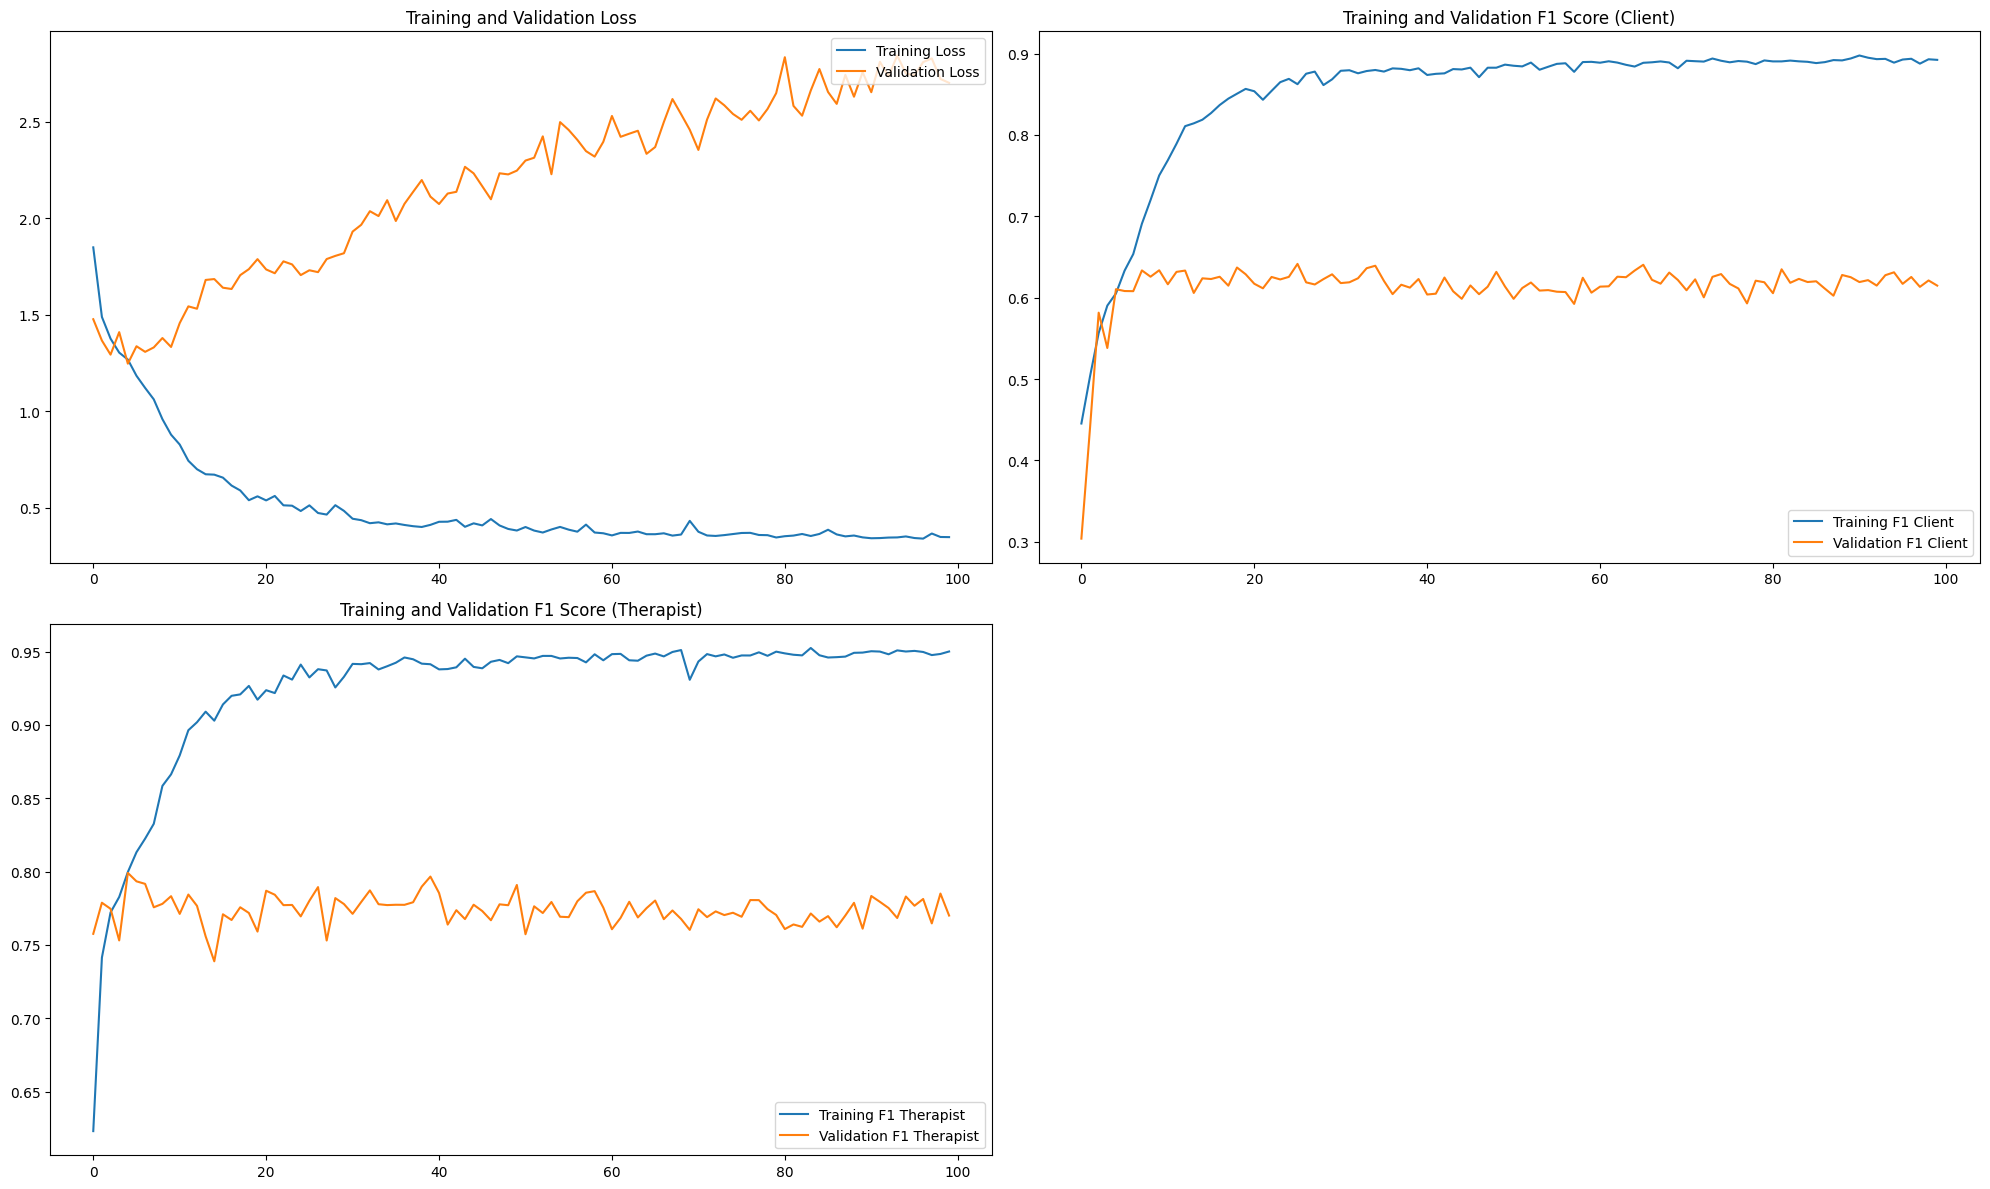

In [18]:
epochs_range = range(epochs)

plt.figure(figsize=(20, 12))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plot training and validation F1 scores for Client
plt.subplot(2, 2, 2)
plt.plot(epochs_range, training_f1_scores_client, label='Training F1 Client')
plt.plot(epochs_range, validation_f1_scores_client, label='Validation F1 Client')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Client)')

# Plot training and validation F1 scores for Therapist
plt.subplot(2, 2, 3)
plt.plot(epochs_range, training_f1_scores_therapist, label='Training F1 Therapist')
plt.plot(epochs_range, validation_f1_scores_therapist, label='Validation F1 Therapist')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Therapist)')

plt.tight_layout()
plt.show()

In [19]:
# Final evaluation and classification report

def evaluate_model(model, dataloader, task_name):
    """
    Evaluates the given model on the data from the dataloader and returns true labels and predictions.
    
    Parameters:
    - model: The model to evaluate.
    - dataloader: DataLoader providing the data.
    - task_name: A string, either "client" or "therapist".
    
    Returns:
    - true_labels: A list of true labels.
    - predictions: A list of model's predictions.
    """
    true_labels = []
    predictions = []

    eval_bar = tqdm(dataloader, desc=f"Evaluating: {task_name} task")
    for client_item, therapist_item, client_label, therapist_label in eval_bar:
        with torch.no_grad():
            client_input_ids, client_attention_mask = client_item['input_ids'].to(device), client_item['attention_mask'].to(device)
            therapist_input_ids, therapist_attention_mask = therapist_item['input_ids'].to(device), therapist_item['attention_mask'].to(device)
            client_label, therapist_label = client_label.to(device), therapist_label.to(device)
            
            if task_name == "client":
                outputs = model(client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name=task_name, use_attention=True)
                preds = torch.argmax(outputs, dim=1)
                true_labels.extend(client_label.cpu().numpy())
            elif task_name == "therapist":
                outputs = model(client_input_ids, client_attention_mask, therapist_input_ids, therapist_attention_mask, task_name=task_name, use_attention=True)
                preds = torch.argmax(outputs, dim=1)
                true_labels.extend(therapist_label.cpu().numpy())
            
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions


# Load the best models
model_client = model
model_client.load_state_dict(torch.load('best_model_client_mtl_2.pth'))
model_client.eval()

model_therapist = model
model_therapist.load_state_dict(torch.load('best_model_therapist_mtl_2.pth'))
model_therapist.eval()

labels_client, preds_client = evaluate_model(model_client, val_loader, "client")
labels_therapist, preds_therapist = evaluate_model(model_therapist, val_loader, "therapist")

# For client task:
print("\\nFinal Classification Report (Client):")
print(classification_report(labels_client, preds_client, target_names=client_class_names))

# For therapist task:
print("\\nFinal Classification Report (Therapist):")
print(classification_report(labels_therapist, preds_therapist, target_names=therapist_class_names))

Evaluating: client task:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating: therapist task:   0%|          | 0/80 [00:00<?, ?it/s]

\nFinal Classification Report (Client):
              precision    recall  f1-score   support

     neutral       0.65      0.51      0.57       332
      change       0.75      0.85      0.80       786
     sustain       0.51      0.42      0.46       150

    accuracy                           0.71      1268
   macro avg       0.64      0.59      0.61      1268
weighted avg       0.70      0.71      0.70      1268

\nFinal Classification Report (Therapist):
                 precision    recall  f1-score   support

       question       0.95      0.86      0.90       445
therapist_input       0.84      0.84      0.84       358
     reflection       0.70      0.84      0.76       280
          other       0.72      0.68      0.70       185

       accuracy                           0.82      1268
      macro avg       0.80      0.80      0.80      1268
   weighted avg       0.83      0.82      0.82      1268

